In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf

import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8994800510211269279
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40075591680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7741031358189882573
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-06-15 07:29:04.809028: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 07:29:05.768444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-06-15 07:29:05.781684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from PIL import Image
from scipy import ndimage

def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

def get_full_scan(folder_path):

    files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    
    a = itkimage.GetMetaData('0028|0030')
    c = itkimage.GetMetaData('0018|0050')
    #print('z spacing ',c)
    #print('xy spacing: ',a)
    mn = 1000
    mx = 0
    for file in (files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')
    for file in (files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n-mn,:,:] = img[0,:,:]
    return full_scan

def dcm_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    return numpyImage, ins

import copy
def get_normalized(scann,mn,mx):
    scan = copy.copy(scann)
    mn = max(mn,np.amin(scan))
    mx = min(mx,np.amax(scan))
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan

def res_scan(nscan,image_size):

    depth_factor = image_size[0]/nscan.shape[0]
    width_factor = image_size[2]/nscan.shape[2]
    height_factor = image_size[1]/nscan.shape[1]
    nscann = copy.copy(nscan)
    nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
    return nscann

def res_mask(nmask,image_size):
    depth_factor = image_size[0]/nmask.shape[0]
    width_factor = image_size[2]/nmask.shape[2]
    height_factor = image_size[1]/nmask.shape[1]

    nmaskk = copy.copy(nmask)
    nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
    return nmaskk

In [3]:
# for k in tqdm(range(len(imgpath))):
#     img = cv2.imread(imgpath[k])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = img[:,20:-19]
#     path = "/home/rabeea/chasedb/images/" + imgpath[k].split('/')[-1][:-4]
#     os.mkdir(path)
#     for i in range(4):
#         for j in range(4):
#             imgg = img[i*240:(i+1)*240,j*240:(j+1)*240]
#             #print(imgg.shape)
#             name = "/home/rabeea/chasedb/images/" + imgpath[k].split('/')[-1][:-4] + '/' + str(i) + str(j) + '.npy'
#             #print(name)
#             np.save(name,imgg)

In [4]:
# for k in tqdm(range(len(imgpath))):
#     maskpath = imgpath[k][:-4] + "_1stHO.png"
#     img = cv2.imread(maskpath)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = img[:,20:-19]
#     for i in range(4):
#         for j in range(4):
#             imgg = img[i*240:(i+1)*240,j*240:(j+1)*240]
#             #print(imgg.shape)
#             name = "/home/rabeea/chasedb/masks1/" + maskpath.split('/')[-1][:-9] + str(i) + str(j) + '.npy'
#             #print(name)
#             np.save(name,imgg)

In [5]:
imgpath = sorted(glob.glob(r"/home/rabeea/chasedb/256/images/*"))
random.Random(42).shuffle(imgpath)
tr = 15
val = 5
ts = 8
trainpath = imgpath[:tr]
valpath = imgpath[tr:tr+val]
testpath = imgpath[-ts:]
print(len(imgpath),len(trainpath), len(valpath), len(testpath))
print(valpath[:3])

28 15 5 8
['/home/rabeea/chasedb/256/images/Image_01R', '/home/rabeea/chasedb/256/images/Image_07R', '/home/rabeea/chasedb/256/images/Image_02L']


In [6]:
trainpathh = []
for path in trainpath:
    trainpathh.append(glob.glob(path+'/*.npy'))
trainpath = [item for sublist in trainpathh for item in sublist]
valpathh = []
for path in valpath:
    valpathh.append(glob.glob(path+'/*.npy'))
valpath = [item for sublist in valpathh for item in sublist]
len(valpath)
testpathh = []
for path in testpath:
    testpathh.append(glob.glob(path+'/*.npy'))
testpath = [item for sublist in testpathh for item in sublist]
print(len(imgpath),len(trainpath), len(valpath), len(testpath))
print(valpath[:3])

28 240 80 128
['/home/rabeea/chasedb/256/images/Image_01R/13.npy', '/home/rabeea/chasedb/256/images/Image_01R/10.npy', '/home/rabeea/chasedb/256/images/Image_01R/32.npy']


In [7]:
"/home/rabeea/chasedb/masks1/" + valpath[0].split('/')[-2] + '_' + valpath[0].split('/')[-1]

'/home/rabeea/chasedb/masks1/Image_01R_13.npy'

In [7]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path, image_size):
    img = np.load(img_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    img_path = "/home/rabeea/chasedb/256/masks1/" + img_path.split('/')[-2] + '_' + img_path.split('/')[-1]
    mask = np.load(img_path)
    #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    #mask = cv2.resize(mask.astype(np.uint8),image_size, interpolation = cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        images_batch = np.empty((self.batch_size,image_size[0],image_size[1],1))
        masks_batch = np.empty((self.batch_size,image_size[0],image_size[1],1),dtype = 'uint8')

        for i in range(len(images_path)):
            #print(images_path[i])
            # Read image and mask
            images_batch[i]= parse_image(images_path[i], self.image_size)
            masks_batch[i] = parse_mask(images_path[i], self.image_size)

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [8]:
image_size = (256,256)
batch_size = 1

epochs = 100

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,batch_size=batch_size)
valid_gen = DataGen(image_size,valpath, batch_size=batch_size)
test_gen = DataGen(image_size,testpath, batch_size=1)

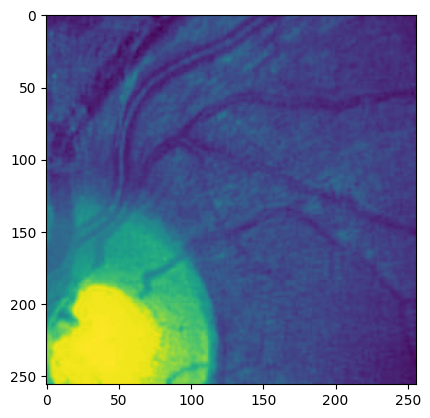

In [9]:
t = train_gen.__getitem__(3)[0]
p = train_gen.__getitem__(3)[1]
plt.imshow(t[0,:,:,0])

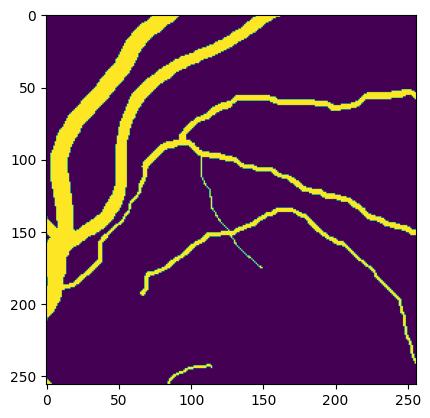

In [10]:
plt.imshow(p[0,:,:,0])

In [11]:
np.unique(p)

array([0, 1], dtype=uint8)

In [12]:

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from einops.layers.tensorflow import Rearrange
import keras_nlp
#import tensorflow_datasets as tfds

def unet(pretrained_weights = None,input_size = (256,256,1), f = 64, embedding_dim = 4, dim = 8, heads = 2):
    inputs = Input(input_size)
    scale = dim ** -0.5
    
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    

    

    up = Conv2D(f*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge = concatenate([conv3,up], axis = 3)
    conv = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv2,up], axis = 3)
    conv = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(1, 1, activation = 'sigmoid')(conv)

    model = Model(inputs = inputs, outputs = conv)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss=dice_loss, metrics = [dice_coef])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [13]:
a= unet()

2023-06-15 07:31:21.665112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [14]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = r"/home/rabeea/logs/unet_chasedb/4layers_f64_350_256.h5"
tensorboard = TensorBoard(log_dir=r"/home/rabeea/logs/unet_chasedb/4layers_f64_350_256", histogram_freq=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]

In [15]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/100


2023-06-15 07:32:13.522239: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801


240/240 [==============================] - 13s 35ms/step - loss: 0.8237 - dice_coef: 0.1763 - val_loss: 0.8144 - val_dice_coef: 0.1856
Epoch 2/100
240/240 [==============================] - 8s 35ms/step - loss: 0.8227 - dice_coef: 0.1773 - val_loss: 0.8135 - val_dice_coef: 0.1865
Epoch 3/100
240/240 [==============================] - 8s 34ms/step - loss: 0.8218 - dice_coef: 0.1782 - val_loss: 0.8125 - val_dice_coef: 0.1875
Epoch 4/100
240/240 [==============================] - 8s 34ms/step - loss: 0.8209 - dice_coef: 0.1791 - val_loss: 0.8116 - val_dice_coef: 0.1884
Epoch 5/100
240/240 [==============================] - 8s 34ms/step - loss: 0.8200 - dice_coef: 0.1800 - val_loss: 0.8107 - val_dice_coef: 0.1893
Epoch 6/100
240/240 [==============================] - 8s 34ms/step - loss: 0.8191 - dice_coef: 0.1809 - val_loss: 0.8098 - val_dice_coef: 0.1902
Epoch 7/100
240/240 [==============================] - 8s 34ms/step - loss: 0.8177 - dice_coef: 0.1823 - val_loss: 0.8089 - val_dice_co

Epoch 57/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1971 - dice_coef: 0.8029 - val_loss: 0.2379 - val_dice_coef: 0.7621
Epoch 58/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1900 - dice_coef: 0.8100 - val_loss: 0.2313 - val_dice_coef: 0.7687
Epoch 59/100
240/240 [==============================] - 7s 31ms/step - loss: 0.1762 - dice_coef: 0.8238 - val_loss: 0.2292 - val_dice_coef: 0.7708
Epoch 60/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1762 - dice_coef: 0.8238 - val_loss: 0.2236 - val_dice_coef: 0.7764
Epoch 61/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1680 - dice_coef: 0.8320 - val_loss: 0.2306 - val_dice_coef: 0.7694
Epoch 62/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1744 - dice_coef: 0.8256 - val_loss: 0.2374 - val_dice_coef: 0.7626
Epoch 63/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1994 - dice_coef: 0.8006 - val_loss: 0.

In [16]:
a.load_weights(filepath)

In [17]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
print('training dice: ',max(acc))
print('validation dice: ',max(val_acc))

training dice:  0.9344664216041565
validation dice:  0.7763860821723938


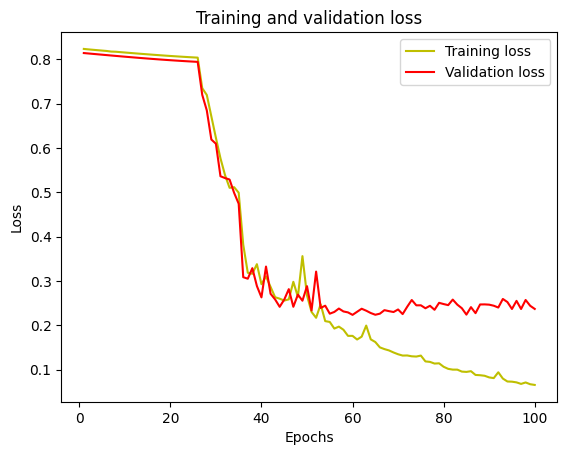

In [18]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

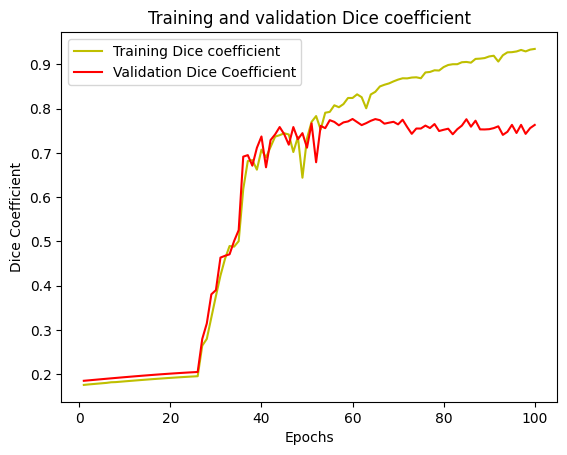

In [19]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [20]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                   | 0/128 [00:00<?, ?it/s]/tmp/ipykernel_2238961/4120540149.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_2238961/4120540149.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|███████████████

at 0.9: dice:  0.6530866649339182
at 0.8: dice:  0.6923264643582294
at 0.7: dice:  0.7129134944282645
at 0.6: dice:  0.7255460176297555
at 0.5: dice:  0.732512981193026
at 0.4: dice:  0.7338844296302993
at 0.3: dice:  0.7275846335349002
at 0.2: dice:  0.7110856788404745
at 0.1: dice:  0.6634326971753391
at 0.05: dice:  0.614427846313161
at 0.01: dice:  0.4682294890195912


# 240

In [17]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
print('training dice: ',max(acc))
print('validation dice: ',max(val_acc))

training dice:  0.9979647994041443
validation dice:  0.7509503960609436


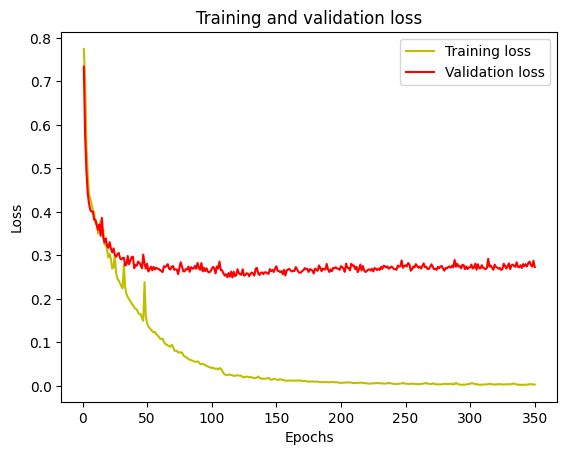

In [18]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

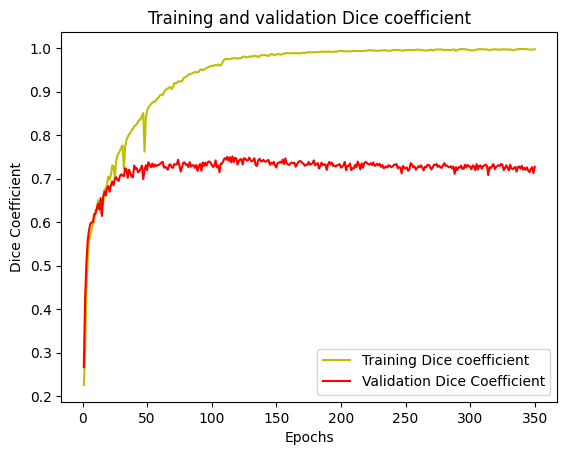

In [19]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [21]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                   | 0/128 [00:00<?, ?it/s]/tmp/ipykernel_1871808/4120540149.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_1871808/4120540149.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|███████████████

at 0.9: dice:  0.713684387247632
at 0.8: dice:  0.7252069037125969
at 0.7: dice:  0.731152034015963
at 0.6: dice:  0.7353268558619772
at 0.5: dice:  0.7386888097320239
at 0.4: dice:  0.7412646506453726
at 0.3: dice:  0.7434262435930918
at 0.2: dice:  0.7453372044190382
at 0.1: dice:  0.7461987825149893
at 0.05: dice:  0.745090326667674
at 0.01: dice:  0.7330720109302667
